In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#no dado original, havia uma coluna sem nome (com os indexes). seria difícil remover assim. Nomeei-a de "A", para priorizar 
#o index do pandas.

# Função para normalizar todas as colunas de um dataframe pelo método de valor mínimo 0 e máximo 1
def normalizar(df):
    resultado = df.copy()
    for coluna in df.columns:
        if df[coluna].max() == 0:
            continue
        else:
            valor_max = df[coluna].max()
            valor_min = df[coluna].min()
            resultado[coluna] = (df[coluna] - valor_min) / (valor_max - valor_min)
    return resultado


In [2]:
#criando o DataFrame "df_chem" (e talvez outros DataFrames)
df = pd.read_csv("Minerals_Database3.csv")  # Importação do dataset para ser utilizado como dataframe
# Remoção de colunas não necessárias para o dataframe

df = df.drop(['A'], axis=1)
df = df.drop(['Name'], axis=1)

dados_cat = df.reindex(df.columns[[0,2,4]], axis = 1) # Remoção de dados categóricos
dados_categoricos = dados_cat.astype("category") # Tratamento de dados para o tipo categórico
newlist = [x for x in range(7,135)] # Range para pegarmos dados que estão em porcentagem
porcent_df = df.reindex(df.columns[newlist], axis = 1) # Coleta dos dados de elementos em porcentagem
df_chem = df.reindex(df.columns[[1,3,5,6,135,136,137]], axis=1) # Reindexação de um dataframe contendo apenas propriedades fisico-químicas
dados_categoricos, df_chem

(     Crystal Structure Diaphaneity Optical
 0                  5.0         0.0     3.0
 1                  4.0         3.0     3.0
 2                  5.0         3.0     3.0
 3                  0.0         0.0     0.0
 4                  2.0         2.0     4.0
 ...                ...         ...     ...
 3107               0.0         0.0     0.0
 3108               0.0         0.0     0.0
 3109               0.0         0.0     0.0
 3110               0.0         0.0     0.0
 3111               0.0         0.0     0.0
 
 [3112 rows x 3 columns],
       Mohs Hardness  Specific Gravity  Refractive Index  Dispersion  \
 0              4.50             3.240             1.580         0.0   
 1              2.75             3.446             1.592         0.0   
 2              2.00             4.420             2.085         0.0   
 3              0.00             0.000             0.000         0.0   
 4              5.50             1.050             1.634         0.0   
 ...        

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

tamanho = 0.25 # Fração de dados escolhida para treino e teste
seed = 2000

i = df_chem.index
i_treino, i_teste = train_test_split(i, test_size=tamanho, random_state = seed)

df_treino = df_chem.loc[i_treino]
df_teste = df_chem.loc[i_teste]

#print(df_treino)
#print()
#print(df_teste)

In [4]:
# Modelo preditivo de base (baseline)

nome = 'df_chem'
atributos = ["Mohs Hardness","Specific Gravity", "Refractive Index", "Dispersion", 'Molar Mass', 'Molar Volume', 'Calculated Density']
target = ["Refractive Index"]

x_treino = df_treino.reindex(atributos, axis=1).values
y_treino = df_treino.reindex(target, axis=1).values
x_teste = df_teste.reindex(atributos, axis=1).values
y_teste = df_teste.reindex(target, axis=1).values

In [5]:
from sklearn.tree import DecisionTreeRegressor

# cria o modelo
modelo_dt = DecisionTreeRegressor(random_state=1024)

# treina o modelo
modelo_dt.fit(x_treino, y_treino)

# realiza uma previsão usando o modelo treinado
previsao = modelo_dt.predict(x_teste)
#print(previsao)

In [6]:
from sklearn.metrics import mean_squared_error

y_verdadeiro = y_teste
y_previsao = modelo_dt.predict(x_teste)

RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared=False)

print(f"O RMSE do modelo árvore de decisão foi de {RMSE}.")

O RMSE do modelo árvore de decisão foi de 0.008309640698291617.


In [7]:
#Hiperparâmetros
from itertools import product

NUM_FOLHAS = 50
NUM_PROFUNDIDADE = 70
#CRITERIO = 'absolute_error'
SPLITTER = "best"
MINIMO_SPLIT = 2
MINIMO_FOLHAS = 1
PESO_FOLHAS = 0.0
MAXIMO_FEATURES = None
IMPUREZA_MINIMO = 0.0
COMPLEXO_ALPHA = 0.0



modelo_dt = DecisionTreeRegressor(
        max_leaf_nodes=NUM_FOLHAS,
        max_depth=NUM_PROFUNDIDADE,
        #criterion=CRITERIO,
        splitter=SPLITTER,
        min_samples_split=MINIMO_SPLIT,
        min_samples_leaf=MINIMO_FOLHAS,
        min_weight_fraction_leaf=PESO_FOLHAS,
        max_features=MAXIMO_FEATURES,
        min_impurity_decrease=IMPUREZA_MINIMO,
        ccp_alpha=COMPLEXO_ALPHA,
        random_state=1024,
    )

modelo_dt.fit(x_treino, y_treino)

y_verdadeiro = y_teste
y_previsao = modelo_dt.predict(x_teste)
RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared=False)

print(
    f"A RMSE do modelo de AD usando max_leaf_nodes={NUM_FOLHAS} "
    f"e max_depth={NUM_PROFUNDIDADE} foi um índice refrativo de de {RMSE:.4f}."
    )

A RMSE do modelo de AD usando max_leaf_nodes=50 e max_depth=70 foi um índice refrativo de de 0.0086.


A RMSE do modelo de baseline foi uma Indice Refrativo de 0.6495
A RMSE do modelo de AD usando max_leaf_nodes=50 e max_depth=70 foi um índice refrativo de de 0.0089.

Desse modo, como a RMSE ddo modelo de AD foi menor, o modelo é mais apto para o dataset.

### Comparação entre hiperparâmetros

In [8]:
#Conjunto 1 de Hiperparâmetros
from itertools import product

NUM_FOLHAS = [None, 30, 60, 100, 150]
NUM_PROFUNDIDADE = [None, 10, 20, 50, 100]
#CRITERIO = 'absolute_error'
#SPLITTER = "best"
MINIMO_SPLIT = [2, 4, 6, 8, 10]
MINIMO_FOLHAS = [1, 2, 4, 6, 8]
#PESO_FOLHAS = 0.0
#MAXIMO_FEATURES = None
#IMPUREZA_MINIMO = 0.0
#COMPLEXO_ALPHA = 0.0




for n_folhas, n_profundidade,min_split,min_folhas in product(NUM_FOLHAS, NUM_PROFUNDIDADE,MINIMO_SPLIT,MINIMO_FOLHAS):
    modelo_dt = DecisionTreeRegressor(
        max_leaf_nodes=n_folhas,
        max_depth=n_profundidade,
        #criterion=criterio,
        #splitter=splitter,
        min_samples_split=min_split,
        min_samples_leaf=min_folhas,
        #min_weight_function_leaf=peso_folhas,
        #max_features=max_features,
        #min_impurity_decrease=impureza,
        #ccp_alpha=alpha,
        random_state=1024,
    )

    modelo_dt.fit(x_treino, y_treino)

    y_verdadeiro = y_teste
    y_previsao = modelo_dt.predict(x_teste)
    RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared=False)

    print(
    f"O RMSE do modelo AD usando max_leaf_nodes={n_folhas} "
    f",max_depth={n_profundidade}"
    f"min_samples_split={min_split}"
    f"e min_samples_leaf={min_folhas}"
    f"foi de {RMSE:.4f}."
    )

O RMSE do modelo AD usando max_leaf_nodes=None ,max_depth=Nonemin_samples_split=2e min_samples_leaf=1foi de 0.0083.
O RMSE do modelo AD usando max_leaf_nodes=None ,max_depth=Nonemin_samples_split=2e min_samples_leaf=2foi de 0.0099.
O RMSE do modelo AD usando max_leaf_nodes=None ,max_depth=Nonemin_samples_split=2e min_samples_leaf=4foi de 0.0103.
O RMSE do modelo AD usando max_leaf_nodes=None ,max_depth=Nonemin_samples_split=2e min_samples_leaf=6foi de 0.0169.
O RMSE do modelo AD usando max_leaf_nodes=None ,max_depth=Nonemin_samples_split=2e min_samples_leaf=8foi de 0.0172.
O RMSE do modelo AD usando max_leaf_nodes=None ,max_depth=Nonemin_samples_split=4e min_samples_leaf=1foi de 0.0051.
O RMSE do modelo AD usando max_leaf_nodes=None ,max_depth=Nonemin_samples_split=4e min_samples_leaf=2foi de 0.0099.
O RMSE do modelo AD usando max_leaf_nodes=None ,max_depth=Nonemin_samples_split=4e min_samples_leaf=4foi de 0.0103.
O RMSE do modelo AD usando max_leaf_nodes=None ,max_depth=Nonemin_sample

O menor valor de RMSE de Indice Refrativo encontrado foi de "0.0050"
Em comparação, a RMSE do modelo de baseline foi uma Indice Refrativo de "0.6495".
Assim, árvore é um modelo melhor do que o baseline, por apresentar um RMSE significativamente menor.

In [9]:
#Conjunto de Hiperparâmetros 2
from itertools import product

NUM_FOLHAS = [None, 30, 60, 100, 150]
NUM_PROFUNDIDADE = [None, 10, 20, 50, 100]
#CRITERIO = 'absolute_error'
#SPLITTER = "best"
#MINIMO_SPLIT = [2, 4, 6, 8, 10]
#MINIMO_FOLHAS = [1, 2, 4, 6, 8]
#PESO_FOLHAS = 0.0
#MAXIMO_FEATURES = None
#IMPUREZA_MINIMO = 0.0
#COMPLEXO_ALPHA = 0.0




for n_folhas, n_profundidade in product(NUM_FOLHAS, NUM_PROFUNDIDADE):
    modelo_dt = DecisionTreeRegressor(
        max_leaf_nodes=n_folhas,
        max_depth=n_profundidade,
        #criterion=criterio,
        #splitter=splitter,
        #min_samples_split=min_split,
        #min_samples_leaf=min_folhas,
        #min_weight_function_leaf=peso_folhas,
        #max_features=max_features,
        #min_impurity_decrease=impureza,
        #ccp_alpha=alpha,
        random_state=1024,
    )

    modelo_dt.fit(x_treino, y_treino)

    y_verdadeiro = y_teste
    y_previsao = modelo_dt.predict(x_teste)
    RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared=False)

    print(
    f"O RMSE do modelo AD usando max_leaf_nodes={n_folhas} e "
    f"max_depth={n_profundidade}"
    f" foi de {RMSE:.4f}."
    )

O RMSE do modelo AD usando max_leaf_nodes=None e max_depth=None foi de 0.0083.
O RMSE do modelo AD usando max_leaf_nodes=None e max_depth=10 foi de 0.0082.
O RMSE do modelo AD usando max_leaf_nodes=None e max_depth=20 foi de 0.0083.
O RMSE do modelo AD usando max_leaf_nodes=None e max_depth=50 foi de 0.0083.
O RMSE do modelo AD usando max_leaf_nodes=None e max_depth=100 foi de 0.0083.
O RMSE do modelo AD usando max_leaf_nodes=30 e max_depth=None foi de 0.0095.
O RMSE do modelo AD usando max_leaf_nodes=30 e max_depth=10 foi de 0.0095.
O RMSE do modelo AD usando max_leaf_nodes=30 e max_depth=20 foi de 0.0095.
O RMSE do modelo AD usando max_leaf_nodes=30 e max_depth=50 foi de 0.0095.
O RMSE do modelo AD usando max_leaf_nodes=30 e max_depth=100 foi de 0.0095.
O RMSE do modelo AD usando max_leaf_nodes=60 e max_depth=None foi de 0.0084.
O RMSE do modelo AD usando max_leaf_nodes=60 e max_depth=10 foi de 0.0084.
O RMSE do modelo AD usando max_leaf_nodes=60 e max_depth=20 foi de 0.0084.
O RMSE 

Com os hiperparâmetros definidos, o menor RMSE foi "0.0082".
Ainda sim foi melhor que a baseline de RMSE = "0.6495".



In [10]:
#Relação folhas com RMSE
lista_RMSE = []
folhas = range(2,150)
for i in folhas:
    modelo_dt = DecisionTreeRegressor(max_leaf_nodes=i,random_state=1024)
    modelo_dt.fit(x_treino, y_treino)
    y_verdadeiro = y_teste
    y_previsao = modelo_dt.predict(x_teste)
    RMSE_valores = mean_squared_error(y_verdadeiro, y_previsao, squared=False)
    lista_RMSE.append(RMSE_valores)
    print(lista_RMSE)

[0.10603798162870977]
[0.10603798162870977, 0.06190515037917329]
[0.10603798162870977, 0.06190515037917329, 0.052656583698828814]
[0.10603798162870977, 0.06190515037917329, 0.052656583698828814, 0.03613479236640775]
[0.10603798162870977, 0.06190515037917329, 0.052656583698828814, 0.03613479236640775, 0.030742645262357298]
[0.10603798162870977, 0.06190515037917329, 0.052656583698828814, 0.03613479236640775, 0.030742645262357298, 0.0267999871920009]
[0.10603798162870977, 0.06190515037917329, 0.052656583698828814, 0.03613479236640775, 0.030742645262357298, 0.0267999871920009, 0.02560060346627608]
[0.10603798162870977, 0.06190515037917329, 0.052656583698828814, 0.03613479236640775, 0.030742645262357298, 0.0267999871920009, 0.02560060346627608, 0.02169128034469259]
[0.10603798162870977, 0.06190515037917329, 0.052656583698828814, 0.03613479236640775, 0.030742645262357298, 0.0267999871920009, 0.02560060346627608, 0.02169128034469259, 0.021652280956778857]
[0.10603798162870977, 0.0619051503791

[Text(0.5, 0, 'Folhas'), Text(0, 0.5, 'RMSE')]

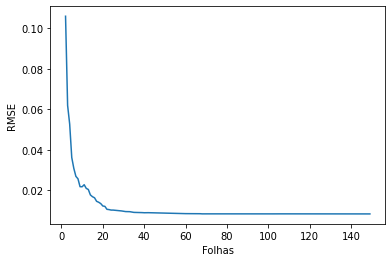

In [11]:
relacao_folha_RMSE = sns.lineplot(x = folhas, y = lista_RMSE)
relacao_folha_RMSE.set(xlabel = "Folhas", ylabel = "RMSE")

In [12]:
#Relação de profundidade com RMSE 
lista_RMSE = []
profundidade = range(1,100)
for i in profundidade:
    modelo_dt = DecisionTreeRegressor(max_depth=i,random_state=1024)
    modelo_dt.fit(x_treino, y_treino)
    y_verdadeiro = y_teste
    y_previsao = modelo_dt.predict(x_teste)
    RMSE_valores = mean_squared_error(y_verdadeiro, y_previsao, squared=False)
    lista_RMSE.append(RMSE_valores)
    print(lista_RMSE)

[0.10603798162870977]
[0.10603798162870977, 0.06190515037917329]
[0.10603798162870977, 0.06190515037917329, 0.03613479236640775]
[0.10603798162870977, 0.06190515037917329, 0.03613479236640775, 0.021691280344692587]
[0.10603798162870977, 0.06190515037917329, 0.03613479236640775, 0.021691280344692587, 0.01657090149033388]
[0.10603798162870977, 0.06190515037917329, 0.03613479236640775, 0.021691280344692587, 0.01657090149033388, 0.01171111801270434]
[0.10603798162870977, 0.06190515037917329, 0.03613479236640775, 0.021691280344692587, 0.01657090149033388, 0.01171111801270434, 0.009089076753880581]
[0.10603798162870977, 0.06190515037917329, 0.03613479236640775, 0.021691280344692587, 0.01657090149033388, 0.01171111801270434, 0.009089076753880581, 0.008453888436620392]
[0.10603798162870977, 0.06190515037917329, 0.03613479236640775, 0.021691280344692587, 0.01657090149033388, 0.01171111801270434, 0.009089076753880581, 0.008453888436620392, 0.008410108347656127]
[0.10603798162870977, 0.0619051503

[Text(0.5, 0, 'Profundidade'), Text(0, 0.5, 'RMSE')]

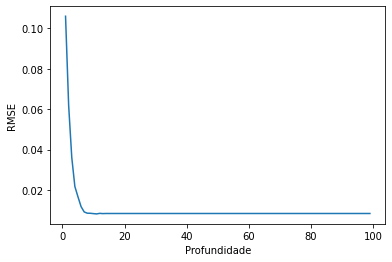

In [13]:
relacao_profundidade_RMSE = sns.lineplot(x = profundidade, y = lista_RMSE)
relacao_profundidade_RMSE.set(xlabel = "Profundidade", ylabel = "RMSE")

In [14]:
#Relação samples split com RMSE
lista_RMSE = []
samples_split = range(2,100)
for i in samples_split:
    modelo_dt = DecisionTreeRegressor(min_samples_split=i,random_state=1024)
    modelo_dt.fit(x_treino, y_treino)
    y_verdadeiro = y_teste
    y_previsao = modelo_dt.predict(x_teste)
    RMSE_valores = mean_squared_error(y_verdadeiro, y_previsao, squared=False)
    lista_RMSE.append(RMSE_valores)
    print(lista_RMSE)

[0.008309640698291617]
[0.008309640698291617, 0.005091230678338151]
[0.008309640698291617, 0.005091230678338151, 0.005080630225151084]
[0.008309640698291617, 0.005091230678338151, 0.005080630225151084, 0.0075963386742514015]
[0.008309640698291617, 0.005091230678338151, 0.005080630225151084, 0.0075963386742514015, 0.007663852963429876]
[0.008309640698291617, 0.005091230678338151, 0.005080630225151084, 0.0075963386742514015, 0.007663852963429876, 0.007666795572851698]
[0.008309640698291617, 0.005091230678338151, 0.005080630225151084, 0.0075963386742514015, 0.007663852963429876, 0.007666795572851698, 0.007802093284440894]
[0.008309640698291617, 0.005091230678338151, 0.005080630225151084, 0.0075963386742514015, 0.007663852963429876, 0.007666795572851698, 0.007802093284440894, 0.008096458743000001]
[0.008309640698291617, 0.005091230678338151, 0.005080630225151084, 0.0075963386742514015, 0.007663852963429876, 0.007666795572851698, 0.007802093284440894, 0.008096458743000001, 0.008289246079087

[Text(0.5, 0, 'S_Split'), Text(0, 0.5, 'RMSE')]

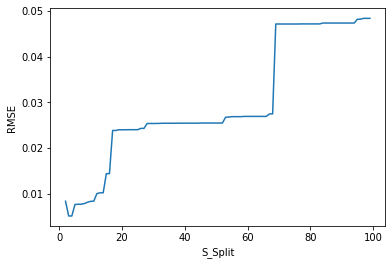

In [15]:
relacao_split_sample_RMSE = sns.lineplot(x = samples_split, y = lista_RMSE)
relacao_split_sample_RMSE.set(xlabel = "S_Split", ylabel = "RMSE")

In [16]:
#Relação de folhas com RMSE
lista_RMSE = []
minimo_folhas = range(1,100)
for i in minimo_folhas:
    modelo_dt = DecisionTreeRegressor(min_samples_leaf=i,random_state=1024)
    modelo_dt.fit(x_treino, y_treino)
    y_verdadeiro = y_teste
    y_previsao = modelo_dt.predict(x_teste)
    RMSE_valores = mean_squared_error(y_verdadeiro, y_previsao, squared=False)
    lista_RMSE.append(RMSE_valores)
    print(lista_RMSE)

[0.008309640698291617]
[0.008309640698291617, 0.009943452659186844]
[0.008309640698291617, 0.009943452659186844, 0.01113896203839358]
[0.008309640698291617, 0.009943452659186844, 0.01113896203839358, 0.01031131160928341]
[0.008309640698291617, 0.009943452659186844, 0.01113896203839358, 0.01031131160928341, 0.017832470525868647]
[0.008309640698291617, 0.009943452659186844, 0.01113896203839358, 0.01031131160928341, 0.017832470525868647, 0.016905446317925156]
[0.008309640698291617, 0.009943452659186844, 0.01113896203839358, 0.01031131160928341, 0.017832470525868647, 0.016905446317925156, 0.01682548976915469]
[0.008309640698291617, 0.009943452659186844, 0.01113896203839358, 0.01031131160928341, 0.017832470525868647, 0.016905446317925156, 0.01682548976915469, 0.017182994203592195]
[0.008309640698291617, 0.009943452659186844, 0.01113896203839358, 0.01031131160928341, 0.017832470525868647, 0.016905446317925156, 0.01682548976915469, 0.017182994203592195, 0.023275795828566287]
[0.00830964069829

[Text(0.5, 0, 'S_Split'), Text(0, 0.5, 'RMSE')]

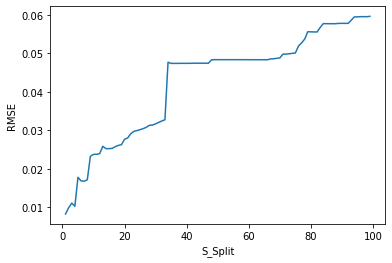

In [17]:
relacao_minimo_folha_RMSE = sns.lineplot(x = minimo_folhas, y = lista_RMSE)
relacao_minimo_folha_RMSE.set(xlabel = "S_Split", ylabel = "RMSE")

Aparentemente, baseado principalmente no comportamento das folhas e profundidade há um sobreajuste.

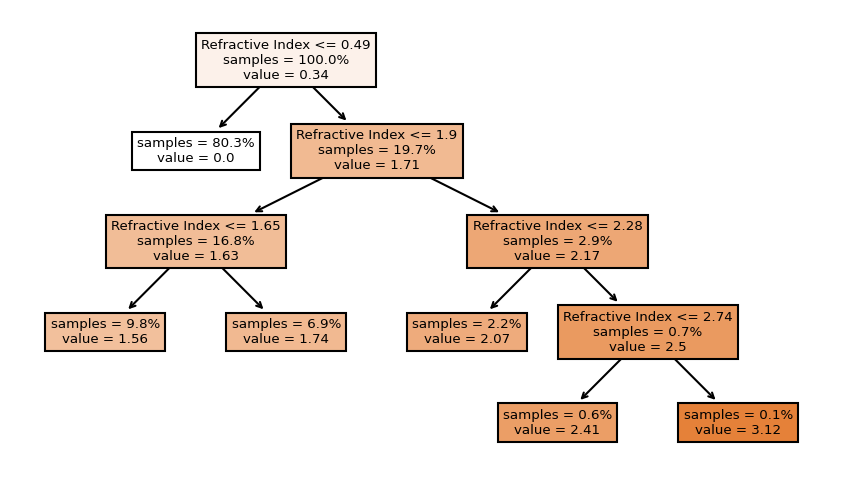

In [20]:
from matplotlib import pyplot as plt
from sklearn import tree

# cria e treina o modelo
modelo_dt = DecisionTreeRegressor(
    max_leaf_nodes=6,
    random_state=1024,
)
modelo_dt.fit(x_treino, y_treino)

# cria os objetos de figura e eixo
fig, axe = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(7, 4),
    dpi=150,
)

# plota o grafo da árvore de decisão
tree.plot_tree(
    modelo_dt,
    feature_names=["Mohs Hardness","Specific Gravity", "Refractive Index", "Dispersion", 'Molar Mass', 'Molar Volume', 'Calculated Density'],
    ax=axe,
    impurity=False,
    filled=True,
    proportion=True,
    precision=2,
)

# mostra o plot para o usuário
plt.show()